In [1]:
import os
import dxcam_cpp as dxcam
from src.utils.windowtools import (
    fuzzy_window_search,
    calculate_aspect_ratio,
    check_aspect_ratio_validity,
    get_monitor_number_from_coords,
    normalise_coords_to_monitor
)
from src.utils.helpers import (
    pre_process,
    pre_process_distbox,
)
import matplotlib.pyplot as plt
from easyocr import Reader
import numpy as np
import cv2
import tkinter as tk
import threading
import time as systime
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


In [2]:
coords = fuzzy_window_search("asphalt")

monitor_id = get_monitor_number_from_coords(coords)

normalised_coords = normalise_coords_to_monitor(coords, monitor_id)

aspect_ratio = calculate_aspect_ratio(normalised_coords)

check_aspect_ratio_validity(aspect_ratio)
print(coords)

[(0, 0, 2560, 1392)]
1
The aspect ratio is reasonable.
(0, 0, 2560, 1392)


In [3]:
# Global vars
camera = dxcam.create(device_idx=0, output_idx=monitor_id)
capturing = True
time = 0
elapsed_ms = 0
percentage = 0

reader = Reader(['en'], gpu=True)  # Still needed for DIST detection

In [4]:
# Grab a frame from the camera
window = camera.grab()

# Extract coordinates from the coords variable
x1, y1, x2, y2 = normalised_coords

capture_coords = (x1, y1, x2, int(y1 + (y2 - y1) / 3.4))

camera.start(region=capture_coords, target_fps=90)

In [5]:
def start_capturing():
    global capturing
    capturing = True
    print("Capturing started")

def stop_capturing():
    global capturing
    capturing = False
    print("Capturing stopped")

def update_time_label():
    time_label.config(text=f"Time: {time}")
    elapsed_label.config(text=f"Elapsed: {elapsed_ms:.2f} ms")
    percentage_label.config(text=f"Percentage: {percentage}")
    # Schedule the next update in 100 ms
    time_label.after(100, update_time_label)

def create_ui():
    global time_label, elapsed_label, percentage_label
    root = tk.Tk()
    root.title("Capture Control")

    start_button = tk.Button(root, text="Start", command=start_capturing, bg="green", fg="white", font=("Helvetica", 16))
    start_button.pack(pady=10)

    stop_button = tk.Button(root, text="Stop", command=stop_capturing, bg="red", fg="white", font=("Helvetica", 16))
    stop_button.pack(pady=10)

    time_label = tk.Label(root, text=f"Time: {time}", font=("Helvetica", 14))
    time_label.pack(pady=10)

    elapsed_label = tk.Label(root, text=f"Elapsed: {elapsed_ms:.2f} ms", font=("Helvetica", 14))
    elapsed_label.pack(pady=10)

    percentage_label = tk.Label(root, text=f"Percentage: {percentage}", font=("Helvetica", 14))
    percentage_label.pack(pady=10)

    # Start periodic UI updates in the main thread
    update_time_label()

    root.mainloop()

ui_thread = threading.Thread(target=create_ui)
ui_thread.start()

In [6]:
# --- Define the CNN Architecture ---
# This must be the same architecture as the one used for training
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- Load the Trained Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=100).to(device)
try:
    model.load_state_dict(torch.load('percentage_cnn.pth'))
    model.eval()  # Set the model to evaluation mode
    print(f"Successfully loaded model on {device}.")
except FileNotFoundError:
    print("Error: 'percentage_cnn.pth' not found. Please ensure the model file is in the correct directory.")
    model = None # Set model to None if loading fails

# --- Define Image Transforms ---
# These must be the same as the transforms used during training
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Successfully loaded model on cuda.


In [ ]:
from IPython.display import clear_output
textarray = []
dist_box = None

# Create a directory for the dataset
DATASET_DIR = "dataset"
os.makedirs(DATASET_DIR, exist_ok=True)

# CNN confidence threshold - adjust this value based on your model's performance
CONFIDENCE_THRESHOLD = 0.5  # Reset bounding box if confidence is below this

def predict_with_cnn(image_array):
    """
    Use the trained CNN to predict the percentage from an image array.
    
    Args:
        image_array: numpy array of the preprocessed image
        
    Returns:
        predicted_percentage: integer from 0-99, or None if prediction fails
    """
    if model is None:
        print("CNN model not loaded")
        return None
        
    try:
        # Convert numpy array to PIL Image
        pil_image = Image.fromarray(image_array)
        
        # Apply the same transforms used during training
        tensor_image = data_transforms(pil_image).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(tensor_image)
            _, predicted = torch.max(outputs, 1)
            confidence = torch.softmax(outputs, 1)[0][predicted].item()
            
        return predicted.item(), confidence
    except Exception as e:
        print(f"CNN prediction error: {e}")
        return None

def the_loop():
    global dist_box
    global capturing
    global textarray
    global camera
    global percentage
    global elapsed_ms

    # Start the loop
    while capturing:
        if capturing:
            start_time = systime.perf_counter()
            window = camera.get_latest_frame()
            height, width, _ = window.shape
            top_right_region = window[50:height, 0:int(width * 0.35)]

            if dist_box is None:
                print("No bounding box found, searching for DIST...")
                preprocessed_region = pre_process(top_right_region)

                results = reader.readtext(preprocessed_region)
                
                # Create a copy of the original region for drawing bounding boxes
                display_image = top_right_region.copy()
                
                dist_found = False
                dist_bbox = None
                dist_index = -1
                
                # First pass: find DIST and draw all detections
                for i, (bbox, text, confidence) in enumerate(results):
                    # Draw all detected bounding boxes in blue
                    bbox_points = np.array(bbox, dtype=np.int32)
                    cv2.polylines(display_image, [bbox_points], True, (255, 0, 0), 2)
                    # Add text label with confidence
                    cv2.putText(display_image, f"{text} ({confidence:.2f})", (int(bbox_points[0][0]), int(bbox_points[0][1] - 5)), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
                    
                    if "dist" in text.lower() and not dist_found:
                        # Get bbox of "DIST" and highlight it in green
                        cv2.polylines(display_image, [bbox_points], True, (0, 255, 0), 3)
                        dist_bbox = np.array(bbox)
                        dist_index = i
                        dist_found = True
                
                # If we found DIST, look for percentage
                if dist_found:
                    dist_x0, dist_y0 = np.min(dist_bbox[:, 0]), np.min(dist_bbox[:, 1])
                    dist_x1, dist_y1 = np.max(dist_bbox[:, 0]), np.max(dist_bbox[:, 1])
                    dist_center_y = (dist_y0 + dist_y1) / 2
                    
                    best_percentage_match = None
                    best_score = 0
                    
                    # Look for percentage indicators with more flexible criteria
                    for j, (bbox, text, confidence) in enumerate(results):
                        if j == dist_index:  # Skip the DIST box itself
                            continue
                            
                        bbox_array = np.array(bbox)
                        nx0, ny0 = np.min(bbox_array[:, 0]), np.min(bbox_array[:, 1])
                        nx1, ny1 = np.max(bbox_array[:, 0]), np.max(bbox_array[:, 1])
                        bbox_center_y = (ny0 + ny1) / 2
                        
                        # More flexible matching criteria
                        text_clean = text.strip().replace(' ', '').replace(',', '').replace('.', '')
                        
                        # Check if it looks like a percentage
                        has_percent = '%' in text_clean
                        has_numbers = any(char.isdigit() for char in text_clean)
                        ends_with_7 = text_clean.endswith('7')  # Sometimes % is read as 7
                        
                        # Position criteria (more flexible)
                        reasonable_y_distance = abs(bbox_center_y - dist_center_y) < 50  # Increased tolerance
                        to_the_right = nx0 > dist_x0  # Just needs to be to the right, not necessarily after dist_x1
                        reasonable_x_distance = (nx0 - dist_x1) < 200  # Within reasonable distance
                        
                        # Calculate a score for this match
                        score = 0
                        if has_percent:
                            score += 50
                        if has_numbers:
                            score += 20
                        if ends_with_7:
                            score += 10
                        if reasonable_y_distance:
                            score += 30
                        if to_the_right:
                            score += 20
                        if reasonable_x_distance:
                            score += 10
                        
                        # Add confidence boost
                        score += confidence * 10
                        
                        print(f"Candidate: '{text}' -> Score: {score:.1f} (y_dist: {abs(bbox_center_y - dist_center_y):.1f}, x_pos: {nx0} vs dist_x1: {dist_x1})")
                        
                        if score > best_score and score > 40:  # Minimum threshold
                            best_score = score
                            best_percentage_match = (j, bbox, text, confidence)
                    
                    # If we found a good percentage match
                    if best_percentage_match is not None:
                        j, next_bbox, next_text, next_confidence = best_percentage_match
                        
                        # Highlight the percentage box in green as well
                        next_bbox_points = np.array(next_bbox, dtype=np.int32)
                        cv2.polylines(display_image, [next_bbox_points], True, (0, 255, 0), 3)
                        
                        # Calculate combined bounding box
                        next_box = np.array(next_bbox)
                        nx0, ny0 = np.min(next_box[:, 0]), np.min(next_box[:, 1])
                        nx1, ny1 = np.max(next_box[:, 0]), np.max(next_box[:, 1])
                        
                        # Extend bounding box to include both with some padding
                        x0 = int(min(dist_x0, nx0)) - 5
                        y0 = int(min(dist_y0, ny0)) - 5
                        x1 = int(max(dist_x1, nx1)) + 5
                        y1 = int(max(dist_y1, ny1)) + 5
                        
                        # Ensure bounds are within image
                        x0 = max(0, x0)
                        y0 = max(0, y0)
                        x1 = min(top_right_region.shape[1], x1)
                        y1 = min(top_right_region.shape[0], y1)
                        
                        print(f"Found DIST + percentage match: '{next_text}' with score {best_score:.1f}")
                    else:
                        # Fallback: just use DIST box with some expansion
                        print("No good percentage match found, using expanded DIST box")
                        x0 = int(dist_x0) - 10
                        y0 = int(dist_y0) - 10
                        x1 = int(dist_x1) + 100  # Expand to the right to catch percentage
                        y1 = int(dist_y1) + 30   # Expand down a bit
                        
                        # Ensure bounds are within image
                        x0 = max(0, x0)
                        y0 = max(0, y0)
                        x1 = min(top_right_region.shape[1], x1)
                        y1 = min(top_right_region.shape[0], y1)
                    
                    # Create the final bounding box
                    dist_box = np.array([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])
                    
                    # Draw the final combined bounding box in red
                    final_box_points = np.array([[x0, y0], [x1, y0], [x1, y1], [x0, y1]], dtype=np.int32)
                    cv2.polylines(display_image, [final_box_points], True, (0, 0, 255), 3)
                
                # Show the image with all bounding boxes when searching for DIST
                plt.figure(figsize=(15, 10))
                plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
                plt.title("DIST Detection - Blue: All detections, Green: DIST+%, Red: Final bbox")
                plt.axis('off')
                plt.show()
                plt.pause(0.001)
            
            clear_output(wait=True)
            
            # If we have the bounding box, crop the image
            if dist_box is not None:
                roi = top_right_region[int(dist_box[0][1]):int(dist_box[2][1]), int(dist_box[0][0]):int(dist_box[1][0])]
                roi = roi[:, int(roi.shape[1] * 23 / 40):]

                # Preprocess the cropped image for CNN
                preprocessed_region = pre_process_distbox(roi, for_cnn=True)

                # Use CNN for recognition
                cnn_result = predict_with_cnn(preprocessed_region)
                
                # Create a visualization showing the full image with all relevant boxes
                display_image = top_right_region.copy()
                
                # Draw the original DIST bounding box in blue
                dist_box_points = np.array(dist_box, dtype=np.int32)
                cv2.polylines(display_image, [dist_box_points], True, (255, 0, 0), 2)
                cv2.putText(display_image, "DIST BOX", (int(dist_box[0][0]), int(dist_box[0][1] - 10)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
                
                # Calculate and draw the actual ROI area (after cropping right side)
                roi_x0 = int(dist_box[0][0]) + int(roi.shape[1] * 23 / 40)  # Adjust for the cropping
                roi_y0 = int(dist_box[0][1])
                roi_x1 = int(dist_box[1][0])
                roi_y1 = int(dist_box[2][1])
                
                # Draw the actual analysis ROI in green
                cv2.rectangle(display_image, (roi_x0, roi_y0), (roi_x1, roi_y1), (0, 255, 0), 3)
                cv2.putText(display_image, "CNN ROI", (roi_x0, roi_y0 - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                
                # If we have a CNN prediction, add it as text
                if cnn_result is not None:
                    predicted_percentage, confidence = cnn_result
                    prediction_text = f"{predicted_percentage}% ({confidence:.2f})"
                    cv2.putText(display_image, prediction_text, (roi_x0, roi_y1 + 25), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                
                # Show the full image with all annotations
                # plt.figure(figsize=(12, 8))
                # plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
                # plt.title("Active Tracking - Blue: DIST box, Green: CNN ROI, Yellow: Prediction")
                # plt.axis('off')
                # plt.show()
                # plt.pause(0.001)

            # Process CNN prediction
            try:
                if cnn_result is not None:
                    predicted_percentage, confidence = cnn_result
                    text2 = f"{predicted_percentage}%"
                    
                    print(f"CNN Prediction: {predicted_percentage}% (confidence: {confidence:.3f})")
                    
                    percentage = text2
                    
                    # Save image to dataset (optional - you might want to disable this in CNN mode)
                    # if confidence > 0.8:  # Only save high-confidence predictions
                    #     sanitized_label = text2.replace('%', 'pct')
                    #     filename = f"{sanitized_label}_{int(systime.time() * 1000)}.png"
                    #     filepath = os.path.join(DATASET_DIR, filename)
                    #     cv2.imwrite(filepath, preprocessed_region)

                    # Reset bounding box if confidence is too low
                    if confidence < CONFIDENCE_THRESHOLD:
                        dist_box = None
                        print(f"Low confidence ({confidence:.3f}), resetting bounding box.")
                else:
                    dist_box = None
                    print("CNN prediction failed, resetting bounding box.")
            except Exception as e:
                print(f"Error processing CNN result: {e}")
                dist_box = None
            
            end_time = systime.perf_counter()    # End timing
            elapsed_ms = (end_time - start_time) * 1000
            print(f"Loop iteration took {elapsed_ms:.2f} ms")

            systime.sleep(0.2)

CNN Prediction: 7% (confidence: 0.017)
Low confidence (0.017), resetting bounding box.
Loop iteration took 416.16 ms
No bounding box found, searching for DIST...


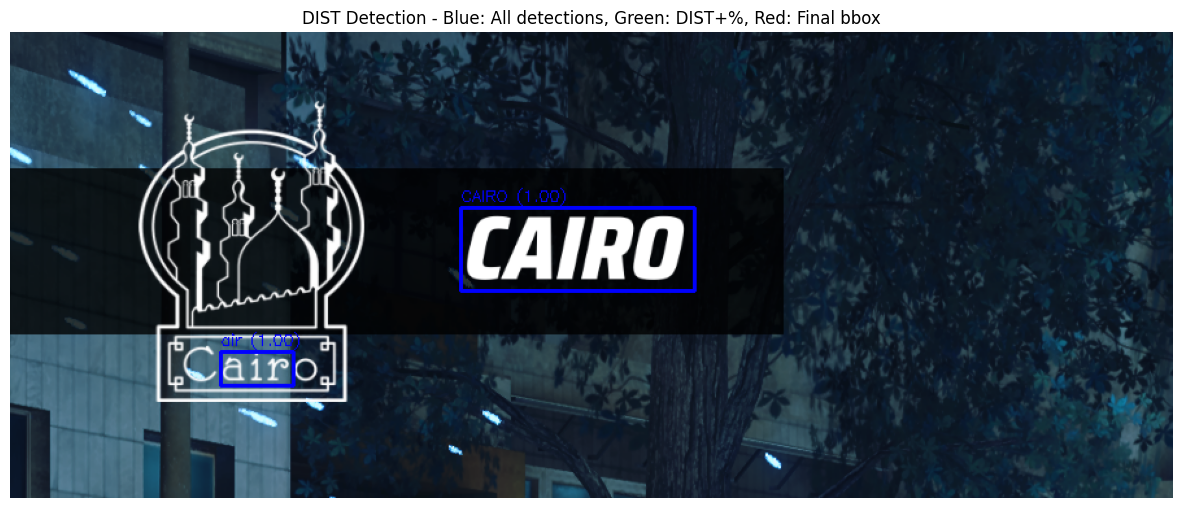

In [ ]:
# Run the main loop
the_loop()